In [1]:
# Import base packages
import os
import json
import pickle
import argparse

# Import external packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
from collections import Counter

In [2]:
# # Read nodes data
paris_100m_nodes = gpd.read_file('https://figshare.com/ndownloader/files/39331691')
paris_100m_nodes = paris_100m_nodes.set_index('osmid')

# # Read edges data
paris_100m_edges = pd.read_csv('https://figshare.com/ndownloader/files/39331688', index_col=0)

# # Visualise columns of edge dataframe
paris_100m_edges.head()[['osmid', 'highway', 'geometry']]

,osmid,highway,geometry
0,"(2569, 2569, 2569)","('tertiary', 'tertiary', 'tertiary')","LINESTRING (2.3694427 48.8215316, 2.3694159 48..."
1,"(34855904, 34855904, 34855904, 34855904)","('primary', 'primary', 'primary', 'primary')","LINESTRING (2.3694427 48.8215316, 2.3697313 48..."
2,"(40001847, 40001847, 40001847)","('secondary', 'secondary', 'secondary')","LINESTRING (2.3694427 48.8215316, 2.3693587 48..."
3,"(41361996, 41361996, 41361996, 41361996, 58441...","('secondary', 'secondary', 'secondary', 'secon...","LINESTRING (2.3694427 48.8215316, 2.3695358 48..."
4,"(370869408, 370869408)","('primary', 'primary')","LINESTRING (2.3694427 48.8215316, 2.3692848 48..."


In [3]:
# Define Functions to Convert Edge to One Type

def most_frequent(string_list):
    """Function to count the number of most occurring labels on an edge and relabel according to most frequent label.

    Args:
        string_list (list): A string of labels of road classification types

    Returns:
        str: The most common label along an edge
    """
    occurence_count = Counter(string_list)
    if occurence_count.most_common(1)[0][0] == 'unclassified':
        try:
            return occurence_count.most_common(2)[1][0]
        except IndexError:
            return 'unclassified'
    else: 
        return occurence_count.most_common(1)[0][0]
    
def convert_labels(row):
    """Function to apply to each edge label, accounting for single entries. If only one entry, skips to next row.

    Args:
        row (str): Entries consisting of string of edge labels

    Returns:
        str: Most commmon label along an edge. 
    """
    try:
        list_of_roads = eval(row)
        return most_frequent(list_of_roads)
        
    except NameError:
        return row
    
# Create new relabelled column `Road Type`
paris_100m_edges['Road Type'] = paris_100m_edges['highway'].apply(convert_labels)

# Visualise new edge dataframe
paris_100m_edges.head()[['osmid', 'highway', 'Road Type', 'geometry']]

,osmid,highway,Road Type,geometry
0,"(2569, 2569, 2569)","('tertiary', 'tertiary', 'tertiary')",tertiary,"LINESTRING (2.3694427 48.8215316, 2.3694159 48..."
1,"(34855904, 34855904, 34855904, 34855904)","('primary', 'primary', 'primary', 'primary')",primary,"LINESTRING (2.3694427 48.8215316, 2.3697313 48..."
2,"(40001847, 40001847, 40001847)","('secondary', 'secondary', 'secondary')",secondary,"LINESTRING (2.3694427 48.8215316, 2.3693587 48..."
3,"(41361996, 41361996, 41361996, 41361996, 58441...","('secondary', 'secondary', 'secondary', 'secon...",secondary,"LINESTRING (2.3694427 48.8215316, 2.3695358 48..."
4,"(370869408, 370869408)","('primary', 'primary')",primary,"LINESTRING (2.3694427 48.8215316, 2.3692848 48..."


In [4]:
# Relabel categories according to OSM TagInfo definition
paris_100m_edges['Road Type'] = paris_100m_edges['Road Type'].replace({'service':5,
                                                            'services':5,
                                                            'residential':4,
                                                            'primary':1,
                                                            'secondary':2,
                                                            'tertiary':2,
                                                            'unclassified':4,
                                                            'primary_link':3,
                                                            'secondary_link':3,
                                                            'trunk':2,
                                                            'motorway_link':3,
                                                            'motorway':1,
                                                            'trunk_link':3,
                                                            'tertiary_link':3,
                                                            'living_street':4,
                                                            'footway':4,
                                                            'cycleway':4,
                                                            'pedestrian':4,
                                                            'bus_stop':3,
                                                            'path':2,
                                                            'track':5,
                                                            'busway':3,
                                                            'crossing':4
                                                            })

# Remove roads under construction, and with no description on OSM TagInfo (e.g., steps).
paris_100m_edges = paris_100m_edges[(paris_100m_edges['Road Type']!='construction') & (paris_100m_edges['Road Type']!='steps')]

# We show the final number of counts for each category
paris_100m_edges['Road Type'].value_counts()

Road Type
4    23412
5    12980
2    10505
1     6344
3      970
Name: count, dtype: int64

In [5]:
# Prepare target label
label = paris_100m_edges['Road Type'].values - 1
label = label.astype(float)
label

array([1., 0., 1., ..., 4., 4., 4.])

In [6]:
# Prepare edge index. First match with index position then convert to torch tensor. 
node_to_id = {}
for i,node in enumerate(paris_100m_nodes.index):
    node_to_id[node] = i
    
# Second, create tensor list for start and end nodes
start_node = [node_to_id[i] for i in paris_100m_edges['u'].values]
end_node = [node_to_id[i] for i in paris_100m_edges['v'].values]
start = torch.Tensor(start_node).to(torch.long)
end = torch.Tensor(end_node).to(torch.long)
edge_index = torch.stack([start, end], dim=0)

# Show edge_index
edge_index

tensor([[    0,     0,     0,  ..., 18893, 18894, 18895],
        [    1,   225, 11407,  ..., 16504, 17681, 10395]])

In [7]:
# Subset dataframe to features of interest
x = np.array(paris_100m_nodes.iloc[:,:-1].values)

# Normalise features
scale = StandardScaler()
x = scale.fit_transform(x)

print(x.shape)

(18896, 39)


In [8]:
# Import torch, training modules and classes
import torch
from torch_geometric.data import InMemoryDataset, Data 
from sklearn.model_selection import train_test_split

# Set manual seed = 0 to allow reproducible results
torch.manual_seed(0)

# Create range of numbers for edge index list(0,1,..., no_of_edges) for subsetting and random split 
indices = list(range(len(paris_100m_edges)))
    
class MyDataset(InMemoryDataset):
    def __init__(self, edge_index, attribute_data, edges_data, x, label, indices, transform=None):
        super(MyDataset, self).__init__('.', transform, None, None)

        data = Data(edge_index=edge_index)
        
        data.num_nodes = len(attribute_data)
        data.num_edges = len(edges_data)
        
        # embedding 
        data.x = torch.from_numpy(x).type(torch.float32)
        
        # labels
        y = torch.from_numpy(label).type(torch.long)
        data.y = y.clone().detach()
        
        data.num_classes = 5 # five main highway categories

        # splitting the data into train, validation and test
        X_train, X_test, y_train, y_test, indices_train, indices_test, = train_test_split(edge_index.T, 
                                                                                        label,
                                                                                        indices,
                                                                                        test_size=0.1, 
                                                                                        random_state=99)
        
        
        # create train and test masks for data
        train_mask = torch.zeros(data.num_edges, dtype=torch.bool)
        test_mask = torch.zeros(data.num_edges, dtype=torch.bool)
        train_mask[indices_train] = True
        test_mask[indices_test] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask

        self.data, self.slices = self.collate([data])

def _download(self):
    return

def _process(self):
    return

def __repr__(self):
    return '{}()'.format(self.__class__.__name__)

# Set torch device to cuda if available or else cpu
#device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Instantiate Dataset 
dataset = MyDataset(edge_index, paris_100m_nodes, paris_100m_edges, x, label, indices)
data = dataset[0]
data = data.to(device)

# Show data object
data

cpu


Data(edge_index=[2, 54211], num_nodes=18896, num_edges=54211, x=[18896, 39], y=[54211], num_classes=5, train_mask=[54211], test_mask=[54211])

In [10]:
# Import helper and utility functions from torch. Import GCNConv class. 
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch.optim import lr_scheduler

# Define model hyper parameters
HIDDEN_DIM = 64
LR = 0.01
EPOCH = 500

class GATv2(torch.nn.Module):
    def __init__(self, hidden_layer, data, heads=4):
        super(GATv2, self).__init__()
        self.gat1 = GATv2Conv(data.num_features, hidden_layer, heads=heads)
        self.gat2 = GATv2Conv(hidden_layer*heads, hidden_layer, heads=1)
        self.linear = nn.Linear(hidden_layer*2, data.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        out= self.gat1(x, edge_index)
        out = F.elu(out)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.gat2(out, edge_index)

        src, dst = edge_index
        out = torch.concat((out[src], out[dst]),dim=1)
        out = self.linear(out)
        
        return F.softmax(out, dim=1)

# Initialise GCN model instance
model = GATv2(HIDDEN_DIM, data).to(device) 

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print(model)

GATv2(
  (gat1): GATv2Conv(39, 64, heads=4)
  (gat2): GATv2Conv(256, 64, heads=1)
  (linear): Linear(in_features=128, out_features=5, bias=True)
)


In [11]:
out = model(data)
train_loss = criterion(out[data.train_mask], data.y[data.train_mask])
print(f'Training Loss: {train_loss}')
training_loss = torch.sum(train_loss)
print(f'Training Loss: {training_loss}')
train_loss.backward()

Training Loss: 1.60616934299469
Training Loss: 1.60616934299469


In [12]:
# scheduler = ReduceLROnPlateau(optimizer, 'min')
epoch_train_val = {}

for epoch in range(1,EPOCH+1):
    #print(f'Epoch: {epoch}/{EPOCH}')
    model.train()
    optimizer.zero_grad()
    out = model(data)
    train_loss = criterion(out[data.train_mask], data.y[data.train_mask])
    training_loss = torch.sum(train_loss)
    train_loss.backward()
    optimizer.step()

    model.eval()
    pred = model(data)
    test_loss = criterion(pred[data.test_mask], data.y[data.test_mask])
    test_loss = torch.sum(test_loss)
    # scheduler.step(test_loss)

    epoch_train_val[epoch] = {'training_loss':training_loss.item(), 'test_loss' :test_loss.item()}

    print(f'Epoch: {epoch}/{EPOCH}- Training Loss: {training_loss}; Testing Loss: {test_loss}')

    if epoch % 20 == 0:
        pred = model(data).argmax(dim=1)
        correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
        acc = int(correct) / int(data.test_mask.sum())

        print(f'Validation accuracy: {acc}.')

Epoch: 1/500
Epoch: 1/500- Training Loss: 1.606338381767273; Testing Loss: 1.4349045753479004
Epoch: 2/500
Epoch: 2/500- Training Loss: 1.4353446960449219; Testing Loss: 1.3942463397979736
Epoch: 3/500
Epoch: 3/500- Training Loss: 1.39412522315979; Testing Loss: 1.3757297992706299
Epoch: 4/500
Epoch: 4/500- Training Loss: 1.3781431913375854; Testing Loss: 1.3691922426223755
Epoch: 5/500
Epoch: 5/500- Training Loss: 1.3729184865951538; Testing Loss: 1.363065242767334
Epoch: 6/500
Epoch: 6/500- Training Loss: 1.3631175756454468; Testing Loss: 1.35297691822052
Epoch: 7/500
Epoch: 7/500- Training Loss: 1.3524028062820435; Testing Loss: 1.3524097204208374
Epoch: 8/500
Epoch: 8/500- Training Loss: 1.353668451309204; Testing Loss: 1.3588742017745972
Epoch: 9/500
Epoch: 9/500- Training Loss: 1.355810523033142; Testing Loss: 1.3535869121551514
Epoch: 10/500
Epoch: 10/500- Training Loss: 1.3497400283813477; Testing Loss: 1.3481661081314087
Epoch: 11/500
Epoch: 11/500- Training Loss: 1.3444688320

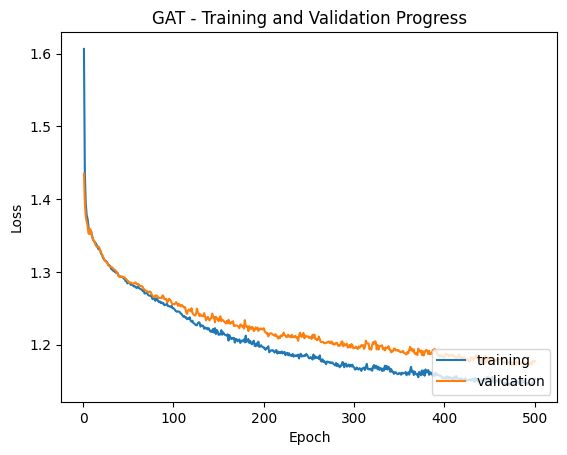

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

train_loss = pd.DataFrame(epoch_train_val).transpose().reset_index()
lines = train_loss.plot.line(x='index', y=['training_loss', 'test_loss'])
plt.title('GAT - Training and Validation Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()